# VSD for Late Show Corpus

This notebook applies the methodology demonstrated in [Story & Bunton (2017)](https://doi.org/10.1121/1.4983342) for calculating density-controlled vowel space area, ideally for measuring vowel space area across task types or mediums. Formant measures are obtained at 5ms intervals of the vowel duration and then normalized. A (200 x 200) grid is generated and for each point on the grid a density value is obtained, equal to the number of formant data points that fall within a 0.1 x 0.1 cube around the grid point. A heatmap is created with scaled density values, showing the relative concentrations of vowel productions. A convex hull measure is taken at several density cut-offs.

This sample run-through contains formant measures of Spanish vowels produced by four female speakers of Bay Area Spanish across a word-list elicitation task `wd` and a sociolinguistic interview `int`.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("data/formants.csv")
data.head()

,Video ID,Vowel,Vowel_onset_time,Time_of_formant_measurements,Time_from_vowel_onset,F1,F2,Participant,Task,Word
0,p113_int,o,0.19,0.195,0.005,438.507357,1371.707968,p113,int,no
1,p113_int,o,0.19,0.200,0.010,438.708664,1345.533822,p113,int,no
2,p113_int,o,0.19,0.205,0.015,438.909970,1319.359676,p113,int,no
3,p113_int,o,0.19,0.210,0.020,439.111277,1293.185530,p113,int,no
4,p113_int,o,0.19,0.215,0.025,439.312583,1267.011384,p113,int,no


In [3]:
df_wd = data[data["Video ID"]=="p120_wd"].copy()
df_int = data[data["Video ID"]=="p120_int"].copy()
print(len(df_wd))
print(len(df_int))

9483
13991


Calculate instances of each vowel.

In [4]:
df_wd.groupby("Vowel")["Vowel_onset_time"].nunique()

Vowel
a    156
e     79
i     57
j     18
o    102
u     16
w      6
Name: Vowel_onset_time, dtype: int64

In [5]:
df_int.groupby("Vowel")["Vowel_onset_time"].nunique()

Vowel
a    279
e    282
i    104
j     52
o    258
u     33
w     24
Name: Vowel_onset_time, dtype: int64

### Removal of outliers

The following code is based on the distribution displayed in boxplots. Formants that fall outside the range defined by 75% + (1.5 x IQR) and by 25% - (1.5 x IQR) are treated as ouliers and that formant measure is removed.

In [6]:
# removes productions with outlier formants
# input df has columns `Participant` and `F1` and `F2`

def rem_outliers(df):
    print("Initial length: ", len(df))
    
    # establish 25% and 75% for each formant
    f1_qrts = df.groupby(['Participant', 'Vowel'])["F1"].describe()[['25%', '75%']]
    f2_qrts = df.groupby(['Participant', 'Vowel'])["F2"].describe()[['25%', '75%']]
    
    # find interquartile range for each formant
    f1_qrts['IQR'] = f1_qrts['75%'] - f1_qrts['25%']
    f2_qrts['IQR'] = f2_qrts['75%'] - f2_qrts['25%']
    
    # determine upper limit for each formant
    f1_qrts['upper'] = f1_qrts['75%'] + (1.5 * f1_qrts['IQR'])
    f2_qrts['upper'] = f2_qrts['75%'] + (1.5 * f2_qrts['IQR'])
    
    # determine lower limit for each formant
    f1_qrts['lower'] = f1_qrts['25%'] - (1.5 * f1_qrts['IQR'])
    f2_qrts['lower'] = f2_qrts['25%'] - (1.5 * f2_qrts['IQR'])
    
    # create smaller df with only limits for each formant
    f1_limits = f1_qrts[['upper','lower']]
    f2_limits = f2_qrts[['upper','lower']]
    
    # merge limits into original df
    df = df.merge(f1_limits, left_on = ["Participant", "Vowel"], right_index = True)
    df = df.merge(f2_limits, left_on = ["Participant", "Vowel"], right_index = True, suffixes = ("_f1", "_f2"))
    
    # drop rows with outlier formants
    df = df[(df["F1"] > df["lower_f1"]) & (df["F1"] < df["upper_f1"])]
    df = df[(df["F2"] > df["lower_f2"]) & (df["F2"] < df["upper_f2"])]

    print("Final length: ", len(df))
    return df

In [7]:
df_wd = rem_outliers(df_wd)
df_int = rem_outliers(df_int)

Initial length:  9483
Final length:  9089
Initial length:  13991
Final length:  13447


We'll want to center our normalized F1 and F2 data (Lobanov z-score normalization) so that the median for each axis is at (0,0) and so that minima are -1 and the maxima are +1. We will call the resulting new columns `F1_vsd` and `F2_vsd`.

In [8]:
import numpy as np

df_wd["F1_vsd"] = df_wd["F1"].apply(lambda x: (x-np.median(df_wd["F1"]))/np.median(df_wd["F1"]))
df_wd["F2_vsd"] = df_wd["F2"].apply(lambda x: (x-np.median(df_wd["F2"]))/np.median(df_wd["F2"]))

df_int["F1_vsd"] = df_int["F1"].apply(lambda x: (x-np.median(df_int["F1"]))/np.median(df_int["F1"]))
df_int["F2_vsd"] = df_int["F2"].apply(lambda x: (x-np.median(df_int["F2"]))/np.median(df_int["F2"]))

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

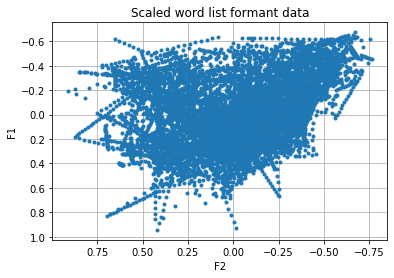

In [10]:
fig, ax = plt.subplots()
ax.plot(df_wd["F2_vsd"], df_wd["F1_vsd"], '.')

# invert x- and y- axes
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(ax.get_xlim()[::-1])

ax.set(xlabel='F2', ylabel='F1',
       title='Scaled word list formant data')
ax.grid()

plt.show()

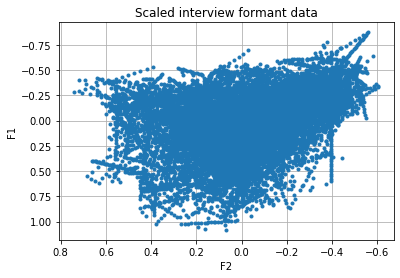

In [11]:
fig, ax = plt.subplots()
ax.plot(df_int["F2_vsd"], df_int["F1_vsd"], '.')

# invert x- and y- axes
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(ax.get_xlim()[::-1])

ax.set(xlabel='F2', ylabel='F1',
       title='Scaled interview formant data')
ax.grid()

plt.show()

## Second step: create grid with discretized dimensions

In [12]:
xvalues = np.flip(np.arange(-1., 1.01, 0.01))
yvalues = np.arange(-1., 1.01, 0.01)

grid = [(round(x, 2), round(y,2)) for x in xvalues for y in yvalues]
len(grid)

40401

## Third step: calculate number of data points that fall within 0.05 radius from each point above

In [13]:
# create dataframes with columns of x and y coordinate data
wd_data = list(zip(df_wd["F2_vsd"], df_wd["F1_vsd"]))
print(len(wd_data))

int_data = list(zip(df_int["F2_vsd"], df_int["F1_vsd"]))
print(len(int_data))

9089
13447


In [14]:
# turn grid into dataframe

grid_df = pd.DataFrame(grid, columns=["x", "y"])
grid_df["coord"] = list(zip(grid_df["x"], grid_df["y"]))
grid_df

,x,y,coord
0,1.0,-1.00,"(1.0, -1.0)"
1,1.0,-0.99,"(1.0, -0.99)"
2,1.0,-0.98,"(1.0, -0.98)"
3,1.0,-0.97,"(1.0, -0.97)"
4,1.0,-0.96,"(1.0, -0.96)"
...,...,...,...
40396,-1.0,0.96,"(-1.0, 0.96)"
40397,-1.0,0.97,"(-1.0, 0.97)"
40398,-1.0,0.98,"(-1.0, 0.98)"
40399,-1.0,0.99,"(-1.0, 0.99)"


The code below may still take a while to run (~5 minutes) since it is looping over 40,000 grid points. However, this code chunk counts the number of points found in the square surrounding the data point, rather than a circle, thus cutting out the steps of Euclidean distance calculations (but altering the lens of view for each point).

1. Word List Data

In [15]:
density_wd = {}
for c in grid:
    # define x and y coordinate
    x = c[0]
    y = c[1]
    
    # define max and min coordinates that form a square of length 0.1 around the coordinate
    x_max = x + 0.05
    x_min = x - 0.05
    y_max = y + 0.05
    y_min = y - 0.05
    
    # pull a subset of data that fall within the box
    opts_wd = df_wd[(df_wd["F2_vsd"] <= x_max) &
               (df_wd["F2_vsd"] >= x_min) &
               (df_wd["F1_vsd"] <= y_max) &
               (df_wd["F1_vsd"] >= y_min)].copy()
    opts_wd_list = list(zip(opts_wd["F2_vsd"], opts_wd["F1_vsd"]))
    
    dens_wd = len(opts_wd_list)
            
    density_wd[c] = dens_wd     
    # print(c) # to check progress

In [16]:
density_int = {}
for c in grid:
    # define x and y coordinate
    x = c[0]
    y = c[1]
    
    # define max and min coordinates that form a square of length 0.1 around the coordinate
    x_max = x + 0.05
    x_min = x - 0.05
    y_max = y + 0.05
    y_min = y - 0.05
    
    # pull a subset of data that fall within the box
    opts_int = df_int[(df_int["F2_vsd"] <= x_max) &
               (df_int["F2_vsd"] >= x_min) &
               (df_int["F1_vsd"] <= y_max) &
               (df_int["F1_vsd"] >= y_min)].copy()
    opts_int_list = list(zip(opts_int["F2_vsd"], opts_int["F1_vsd"]))
    
    dens_int = len(opts_int_list)
            
    density_int[c] = dens_int    
    # print(c) # to check progress

In [17]:
density_wd_df = pd.DataFrame(density_wd.items())
density_int_df = pd.DataFrame(density_int.items())

In [18]:
density_wd_df = density_wd_df.rename(columns = {0: "coord", 1:"density"})
density_int_df = density_int_df.rename(columns = {0: "coord", 1:"density"})

In [19]:
grid_wd_df = grid_df.join(density_wd_df.set_index('coord'), on="coord")
grid_int_df = grid_df.join(density_int_df.set_index('coord'), on="coord")

## Step four: normalize density measures

Scaled so that density measures range from 0 to 1.

In [20]:
grid_wd_df["density_norm"] = grid_wd_df["density"].apply(lambda x: x/grid_wd_df["density"].max())
grid_int_df["density_norm"] = grid_int_df["density"].apply(lambda x: x/grid_int_df["density"].max())

## Step five: plot in 3D space

In [21]:
import seaborn as sns

In [22]:
grid_wd_df_pivot = pd.pivot_table(grid_wd_df,
                    index='y',
                    values='density_norm',
                    columns='x')

# reindex column order to reflect standard representation of vowel formant space
columns = grid_wd_df_pivot.columns.tolist()
columns = columns[::-1]
grid_wd_df_pivot = grid_wd_df_pivot[columns]

grid_wd_df_pivot.head()

x,1.00,0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,...,-0.91,-0.92,-0.93,-0.94,-0.95,-0.96,-0.97,-0.98,-0.99,-1.00
y,,,,,,,,,,,,,,,,,,,,,
-1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
grid_int_df_pivot = pd.pivot_table(grid_int_df,
                    index='y',
                    values='density_norm',
                    columns='x')

# reindex column order to reflect standard representation of vowel formant space
columns = grid_int_df_pivot.columns.tolist()
columns = columns[::-1]
grid_int_df_pivot = grid_int_df_pivot[columns]

grid_int_df_pivot.head()

x,1.00,0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,...,-0.91,-0.92,-0.93,-0.94,-0.95,-0.96,-0.97,-0.98,-0.99,-1.00
y,,,,,,,,,,,,,,,,,,,,,
-1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


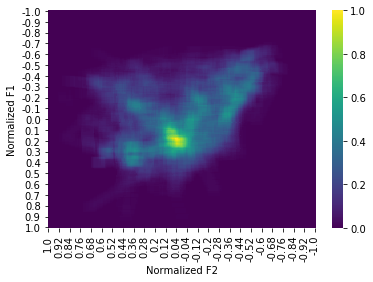

In [24]:
midpoint_wd = (grid_wd_df_pivot.values.max() - grid_wd_df_pivot.values.min()) / 2
sns.heatmap(grid_wd_df_pivot, cmap="viridis", center=midpoint_wd)
plt.xlabel('Normalized F2')
plt.ylabel('Normalized F1')
plt.show()

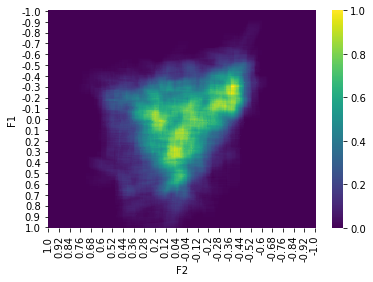

In [25]:
midpoint_int = (grid_int_df_pivot.values.max() - grid_int_df_pivot.values.min()) / 2
sns.heatmap(grid_int_df_pivot, cmap="viridis", center=midpoint_int)
plt.xlabel('F2')
plt.ylabel('F1')
plt.show()

Based on the plots above, this speaker's production are more centralized in the word list elicitation task than the sociolinguistic interview. This could possibly be attributed to all the elicitations being single utterances, rather than being placed in carrier phrases.

## Step six: calculate convexhull area at density cutoff of 0.25, 0.2, 0.15 and 0.1

In [26]:
from scipy.spatial import ConvexHull

In [27]:
# pull out coordinates with various density cutoffs

cutoffs = [0.10, 0.15, 0.20, 0.25]

areas_list = []

for c in cutoffs:
    grid_wd_density = grid_wd_df[grid_wd_df["density_norm"] >= c].copy()
    grid_int_density = grid_int_df[grid_int_df["density_norm"] >= c].copy()
    
    points_tuples_wd = list(grid_wd_density["coord"])
    points_tuples_int = list(grid_int_density["coord"])
    
    points_wd = [list(k) for k in points_tuples_wd]
    points_int = [list(k) for k in points_tuples_int]
    
    hull_wd = ConvexHull(points_wd)
    hull_int = ConvexHull(points_int)
    
    area_wd = hull_wd.area
    area_int = hull_int.area

    areas = {"Task": ["wd", "int"], "Area": [area_wd, area_int], "Cutoff": c}
    areas_list.append(areas)

In [28]:
areas_list

[{'Task': ['wd', 'int'],
  'Area': [4.204127534625412, 4.244624354572868],
  'Cutoff': 0.1},
 {'Task': ['wd', 'int'],
  'Area': [3.969756473602206, 4.03484347894266],
  'Cutoff': 0.15},
 {'Task': ['wd', 'int'],
  'Area': [3.765994804347634, 3.8573595910491383],
  'Cutoff': 0.2},
 {'Task': ['wd', 'int'],
  'Area': [3.4075900090049123, 3.600412211277579],
  'Cutoff': 0.25}]

In [29]:
areas_df = pd.DataFrame(areas_list)
areas_df

,Task,Area,Cutoff
0,"[wd, int]","[4.204127534625412, 4.244624354572868]",0.10
1,"[wd, int]","[3.969756473602206, 4.03484347894266]",0.15
2,"[wd, int]","[3.765994804347634, 3.8573595910491383]",0.20
3,"[wd, int]","[3.4075900090049123, 3.600412211277579]",0.25


In [30]:
areas_df_task = areas_df.explode('Task')
areas_df_task = areas_df_task.drop(["Area", "Cutoff"], axis = 1)
areas_df_area = areas_df.explode('Area')
areas_df_area = areas_df_area.drop("Task", axis = 1)
areas_df = pd.concat([areas_df_task, areas_df_area], axis = 1)
areas_df

,Task,Area,Cutoff
0,wd,4.20413,0.10
0,int,4.24462,0.10
1,wd,3.96976,0.15
1,int,4.03484,0.15
2,wd,3.76599,0.20
2,int,3.85736,0.20
3,wd,3.40759,0.25
3,int,3.60041,0.25


In [31]:
areas_df.to_csv("data/hull_areas.csv", index = False)

## Define function to calculate vowel space density

Synthesize code chunks above into one function that will take an input df with multiple speakers in two task types and will return a dataframe with columns: `Participant`, `Area`, `Cutoff`, and `Task`, where `Task` will have the two levels `wd` and `int`.

In [34]:
def vsd(df):
    import pandas as pd
    import numpy as np
    from scipy.spatial import ConvexHull
    
    # get lists of guests in dataset
    parts = list(df['Participant'].unique())
        
    # define empty list to fill with participant values in form of dataframes
    areas_all = []
    
    # define necessary functions and global variables
    ################################################################################
   
    def rem_outliers(df):
        print("Initial length: ", len(df))
    
        # establish 25% and 75% for each formant
        f1_qrts = df.groupby(['Participant', 'Vowel'])["F1"].describe()[['25%', '75%']]
        f2_qrts = df.groupby(['Participant', 'Vowel'])["F2"].describe()[['25%', '75%']]
    
        # find interquartile range for each formant
        f1_qrts['IQR'] = f1_qrts['75%'] - f1_qrts['25%']
        f2_qrts['IQR'] = f2_qrts['75%'] - f2_qrts['25%']
    
        # determine upper limit for each formant
        f1_qrts['upper'] = f1_qrts['75%'] + (1.5 * f1_qrts['IQR'])
        f2_qrts['upper'] = f2_qrts['75%'] + (1.5 * f2_qrts['IQR'])
    
        # determine lower limit for each formant
        f1_qrts['lower'] = f1_qrts['25%'] - (1.5 * f1_qrts['IQR'])
        f2_qrts['lower'] = f2_qrts['25%'] - (1.5 * f2_qrts['IQR'])
    
        # create smaller df with only limits for each formant
        f1_limits = f1_qrts[['upper','lower']]
        f2_limits = f2_qrts[['upper','lower']]
    
        # merge limits into original df
        df = df.merge(f1_limits, left_on = ["Participant", "Vowel"], right_index = True)
        df = df.merge(f2_limits, left_on = ["Participant", "Vowel"], right_index = True, suffixes = ("_f1", "_f2"))
    
        # drop rows with outlier formants
        df = df[(df["F1"] > df["lower_f1"]) & (df["F1"] < df["upper_f1"])]
        df = df[(df["F2"] > df["lower_f2"]) & (df["F2"] < df["upper_f2"])]

        print("Final length: ", len(df))
        return df
    
    ####################################################################################
    
    # define variable `grid`
    xvalues = np.flip(np.arange(-1., 1.01, 0.01))
    yvalues = np.arange(-1., 1.01, 0.01)

    grid = [(round(x, 2), round(y,2)) for x in xvalues for y in yvalues]
    
    # turn `grid` into dataframe
    grid_df = pd.DataFrame(grid, columns=["x", "y"])
    grid_df["coord"] = list(zip(grid_df["x"], grid_df["y"]))
    
    #####################################################################################
    
    # define function get_density
    def density(grid, df):
        density = {}
        for c in grid:
            # define x and y coordinate
            x = c[0]
            y = c[1]
    
            # define max and min coordinates that form a square of length 0.1 around the coordinate
            x_max = x + 0.05
            x_min = x - 0.05
            y_max = y + 0.05
            y_min = y - 0.05
    
            # pull a subset of data that fall within the box
            opts = df[(df["F2_vsd"] <= x_max) &
               (df["F2_vsd"] >= x_min) &
               (df["F1_vsd"] <= y_max) &
               (df["F1_vsd"] >= y_min)].copy()
            opts_list = list(zip(opts["F2_vsd"], opts["F1_vsd"]))
    
            dens = len(opts_list)
            
            density[c] = dens
        return(density)
    
    ##################################################################################

    for i in parts:
        print("\n",i)
        
        # get subset of data for speaker across modality
        df_wd = df[(df["Participant"]==i) & (df["Task"]== "wd")].copy()
        df_int = df[(df["Participant"]==i) & (df["Task"]== "int")].copy()
        
        # remove outliers        
        df_wd = rem_outliers(df_wd)
        df_int = rem_outliers(df_int)   
        
        # scale formant data      
        df_wd["F1_vsd"] = df_wd["F1"].apply(lambda x: (x-np.median(df_wd["F1"]))/np.median(df_wd["F1"]))
        df_wd["F2_vsd"] = df_wd["F2"].apply(lambda x: (x-np.median(df_wd["F2"]))/np.median(df_wd["F2"]))
        df_int["F1_vsd"] = df_int["F1"].apply(lambda x: (x-np.median(df_int["F1"]))/np.median(df_int["F1"]))
        df_int["F2_vsd"] = df_int["F2"].apply(lambda x: (x-np.median(df_int["F2"]))/np.median(df_int["F2"]))
        
        # change format of data
        wd_data = list(zip(df_wd["F2_vsd"], df_wd["F1_vsd"]))
        int_data = list(zip(df_int["F2_vsd"], df_int["F1_vsd"]))
        
        # get density for each point across the modalities
        density_wd = density(grid, df_wd)
        density_int = density(grid, df_int)
        
        # generate dfs
        density_wd_df = pd.DataFrame(density_wd.items())
        density_int_df = pd.DataFrame(density_int.items())
       
        # change column names
        density_wd_df = density_wd_df.rename(columns = {0: "coord", 1:"density"})
        density_int_df = density_int_df.rename(columns = {0: "coord", 1:"density"})
        
        # create grid dataframes
        grid_wd_df = grid_df.join(density_wd_df.set_index('coord'), on="coord")
        grid_int_df = grid_df.join(density_int_df.set_index('coord'), on="coord")
        
        # scale density measures
        grid_wd_df["density_norm"] = grid_wd_df["density"].apply(lambda x: x/grid_wd_df["density"].max())
        grid_int_df["density_norm"] = grid_int_df["density"].apply(lambda x: x/grid_int_df["density"].max())
        
        # pull out coordinates at various density cutoffs and get areas
        cutoffs = [0.10, 0.15, 0.20, 0.25]

        areas_list = []

        for c in cutoffs:
            grid_wd_density = grid_wd_df[grid_wd_df["density_norm"] >= c].copy()
            grid_int_density = grid_int_df[grid_int_df["density_norm"] >= c].copy()
    
            points_tuples_wd = list(grid_wd_density["coord"])
            points_tuples_int = list(grid_int_density["coord"])
    
            points_wd = [list(k) for k in points_tuples_wd]
            points_int = [list(k) for k in points_tuples_int]
    
            hull_wd = ConvexHull(points_wd)
            hull_int = ConvexHull(points_int)
    
            area_wd = hull_wd.area
            area_int = hull_int.area

            areas = {"Task": ["wd", "int"], "Area": [area_wd, area_int], "Cutoff": c}
            areas_list.append(areas)
            
        # to show progress while running, print areas at density cutoff of 0.25
        print("Wordlist, Interview areas are: ", areas_list[3]["Area"])
        
        # generate dataframe for this participant and reformat
        areas_df = pd.DataFrame(areas_list)
        areas_df_task = areas_df.explode('Task')
        areas_df_task = areas_df_task.drop(["Area", "Cutoff"], axis = 1)
        areas_df_area = areas_df.explode('Area')
        areas_df_area = areas_df_area.drop("Task", axis = 1)
        areas_df = pd.concat([areas_df_task, areas_df_area], axis = 1)

        # append dataframe to list of dataframes
        areas_all.append(areas_df)
 
    # return dataframe of areas
    areas = pd.concat(areas_all)
    
    return areas

In [35]:
areas = vsd(data)


 p113
Initial length:  10377
Final length:  9069
Initial length:  27846
Final length:  26386
Wordlist, Interview areas are:  [2.3886610769782477, 3.003401301488372]

 p115
Initial length:  8018
Final length:  7539
Initial length:  23503
Final length:  22144
Wordlist, Interview areas are:  [2.390959570869891, 3.100949131078444]

 p120
Initial length:  9483
Final length:  9089
Initial length:  13991
Final length:  13447
Wordlist, Interview areas are:  [3.4075900090049123, 3.600412211277579]

 p124
Initial length:  8127
Final length:  7257
Initial length:  14177
Final length:  12821
Wordlist, Interview areas are:  [1.9382488265672349, 2.5530114448168555]


In [36]:
areas.head()

,Task,Area,Cutoff
0,wd,3.42307,0.10
0,int,3.90286,0.10
1,wd,3.03537,0.15
1,int,3.59705,0.15
2,wd,2.4988,0.20


In [37]:
areas.to_csv("areas.csv", index = False)